In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
# import warnings
# warnings.filterwarnings('ignore')

plt.style.use('ggplot')

## Read & Format Data
df_test = pd.read_csv('all/application_test.csv')
df_train = pd.read_csv('all/application_train.csv')
df_train.head()
df_train.shape


(307511, 122)

In [2]:
pd.set_option('display.max_columns', None)

##Testing data
print('Training data shape: ', df_train.shape)
df_train.head()

##Testing data
print('Testing data shape: ', df_test.shape)
df_test.head()

###
#EDA: Exploratory Data Analisys 
####

##Examine missing values

def missing_values_table(df):
    
    # Total missing values
    mis_val = df_train.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df_train.isnull().sum() / len(df_train)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # print(mis_val_table)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    # print(mis_val_table_ren_columns)

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) + 
           " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# Missing values statistics
missing_values = missing_values_table(df_train)
missing_values.head(67)

# Number of each type of column
print(df_train.dtypes.value_counts())


Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)
Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
float64    65
int64      41
object     16
dtype: int64


In [3]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df_train:
    if df_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_train[col])
            # Transform both training and testing data
            df_train[col] = le.transform(df_train[col])
            df_test[col] = le.transform(df_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [4]:
app_train = df_train
app_test = df_test

In [5]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)


Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)
count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64
count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


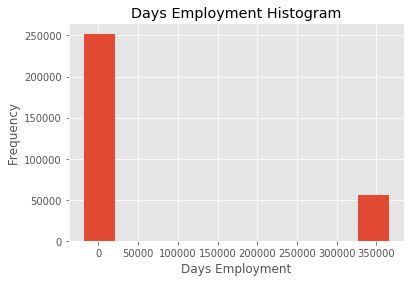

In [6]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

# ###
# Check for anomalies /errors in data
# ###

##Convert birth data to years
print((app_train['DAYS_BIRTH'] / -365).describe())

print(app_train['DAYS_EMPLOYED'].describe())
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

##Do same to testing data
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

In [7]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [8]:
# # Polynomial Features

# One simple feature construction method is called polynomial features. In this method, 
# we make features that are powers of existing features as well as interaction terms between
# existing features. For example, we can create variables EXT_SOURCE_1^2 and EXT_SOURCE_2^2 
# and also variables such as EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, 
# EXT_SOURCE_1^2 x  EXT_SOURCE_2^2, and so on. These features that are a combination of 
# multiple individual variables are called interaction terms because they capture the 
# interactions between variables. In other words, while two variables by themselves may not 
# have a strong influence on the target, combining them together into a single interaction 
# variable might show a relationship with the target. Interaction terms are commonly used 
# in statistical models to capture the effects of multiple variables, but I do not see them 
# used as often in machine learning. Nonetheless, we can try out a few to see if they might
# help our model to predict whether or not a client will repay a loan.

# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

#This creates a considerable number of new features. 
#To get the names we have to use the polynomial features get_feature_names method.

# Get feature names 
print(poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15])

# Now, we can see whether any of these new features are correlated with the target.

# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))
# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))


Polynomial Features shape:  (307511, 35)
['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH', 'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2', 'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2']
EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT

In [9]:
# Several of the new variables have a greater (in terms of absolute magnitude) 
# correlation with the target than the original features. When we build machine 
# learning models, we can try with and without these features to determine if they
# actually help the model learn.
# We will add these features to a copy of the training and testing data and then
# evaluate models with and without the features. Many times in machine learning, 
# the only way to know if an approach will work is to try it out!

# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)



Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


In [10]:
poly_features.shape

(307511, 37)

In [11]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train_poly:
    train = app_train_poly.drop(columns = ['TARGET'])
else:
    train = app_train_poly.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test_poly.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# # Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

target=poly_features['TARGET']

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)
print('Testing target shape: ', target.shape)

Training data shape:  (307511, 275)
Testing data shape:  (48744, 275)
Testing target shape:  (307511,)


In [12]:
app_train_poly.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'EXT_SOURCE_2^3', 'EXT_SOURCE_2^2 EXT_SOURCE_3',
       'EXT_SOURCE_2^2 DAYS_BIRTH', 'EXT_SOURCE_2 EXT_SOURCE_3^2',
       'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH', 'EXT_SOURCE_2 DAYS_BIRTH^2',
       'EXT_SOURCE_3^3', 'EXT_SOURCE_3^2 DAYS_BIRTH',
       'EXT_SOURCE_3 DAYS_BIRTH^2', 'DAYS_BIRTH^3'],
      dtype='object', length=275)

In [13]:
target == train_labels

0         True
1         True
2         True
3         True
4         True
5         True
6         True
7         True
8         True
9         True
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20        True
21        True
22        True
23        True
24        True
25        True
26        True
27        True
28        True
29        True
          ... 
307481    True
307482    True
307483    True
307484    True
307485    True
307486    True
307487    True
307488    True
307489    True
307490    True
307491    True
307492    True
307493    True
307494    True
307495    True
307496    True
307497    True
307498    True
307499    True
307500    True
307501    True
307502    True
307503    True
307504    True
307505    True
307506    True
307507    True
307508    True
307509    True
307510    True
Name: TARGET, Length: 307511, dtype: bool

In [14]:
# Import necessary modules
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

##Create X y split of Data
# X_train = train
# y_train = target
# print(X_tr_train)
# print(y_tr_train.shape)

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(train,train_labels,test_size=0.3,random_state=42)

# Instantiate classifier: 
logreg = LogisticRegression()
### C = 0.5 : 0.739
### C = 0.0001 : 0.719 (though it was 0.69 something when first submitted below and trained on all train data) 
### C = default : 0.739

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the internal test data: y_pred
y_pred = logreg.predict(X_test)

# Generate the confusion matrix and classification report
# print(confusion_matrix(y_tr_test, y_pred))
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.92      1.00      0.96     84841
          1       0.51      0.01      0.02      7413

avg / total       0.89      0.92      0.88     92254



In [15]:
# from sklearn.linear_model import LogisticRegression

# # Make the model with the specified regularization parameter
# log_reg = LogisticRegression(C = 0.0001) ##lower C regularization param to try DECREASE OVERFITTING

# # Train on the training data
# log_reg.fit(train, train_labels)

In [18]:
#Submission predict on Kaggle full test set
logreg.fit(train, target) 
###comments next try runnin logreg (no underscore) running C default or C=0.5 on full training set

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
kaggle_pred = logreg.predict_proba(test)[:, 1]
kaggle_pred[:1000]

array([0.05286526, 0.20738687, 0.03744121, 0.03625249, 0.12412711,
       0.02288222, 0.01986048, 0.09604344, 0.01309176, 0.10441817,
       0.06304061, 0.08069987, 0.17858764, 0.09717929, 0.09456429,
       0.13645592, 0.06907401, 0.02984989, 0.06361002, 0.04040932,
       0.02612618, 0.00622442, 0.03308466, 0.08115877, 0.0455044 ,
       0.13147086, 0.09946963, 0.06136139, 0.0452302 , 0.08524274,
       0.01378928, 0.01993507, 0.17693411, 0.01786268, 0.02013388,
       0.10779645, 0.01243316, 0.22645567, 0.01362765, 0.16680423,
       0.15003578, 0.0157484 , 0.09054513, 0.05055941, 0.10739574,
       0.1427296 , 0.03913939, 0.15256649, 0.07268571, 0.09812334,
       0.05963197, 0.03230525, 0.12651438, 0.02619251, 0.11769903,
       0.03684067, 0.04266657, 0.15418881, 0.14948818, 0.09537225,
       0.0323689 , 0.0578861 , 0.01962683, 0.02648293, 0.01341535,
       0.07081698, 0.17102615, 0.02959103, 0.03648329, 0.04939473,
       0.04472111, 0.12450481, 0.02913576, 0.14073701, 0.43458

In [20]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
# print(submit)
print(np.array(kaggle_pred))
submit['TARGET'] = kaggle_pred
# print(submit)

submit.head()

# Save the submission to a csv file
submit.to_csv('kaggle_pred.csv', index = False) 

##Score: 0.739

[0.05286526 0.20738687 0.03744121 ... 0.05195521 0.05335522 0.13628023]


/Volumes/Macintosh HD /Users/stephanviollier/CodingProjects/ix/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [21]:
###comments next try runnin logreg running C default or C=0.5 on full training set

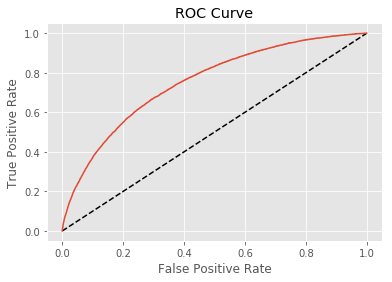

In [22]:
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [23]:
##Cross Validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Perform 3-fold CV
cvscores_3 = cross_val_score(logreg,train,target,cv=3)
print(np.mean(cvscores_3))

0.9193524785308198
